In [ ]:
#Registration Number: 1803123
#Importing all the required libraries
import warnings
import pandas as pd
import numpy as np
import sklearn
import string
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns

import bs4
from bs4 import BeautifulSoup
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix

#inline the graphs
%matplotlib inline
#ignore unnecessary warnings
warnings.filterwarnings("ignore") 

#download stopwords and wordnet for pre-processing
nltk.download('stopwords')
nltk.download('wordnet')
pattern = re.compile('[^a-zA-Z0-9]')

#The nltk version to be used is 3.7.
#The scikit-learn version to be used is 1.0.2.
#The beautifulsoup4 version to be used is 4.11.1.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sorin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sorin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Dataset content (Reviews, collumns):  (50000, 2)

The look of the dataset:

<bound method NDFrame.describe of                                                   review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]>

Review of the dataset destribution:



<AxesSubplot:xlabel='sentiment', ylabel='count'>

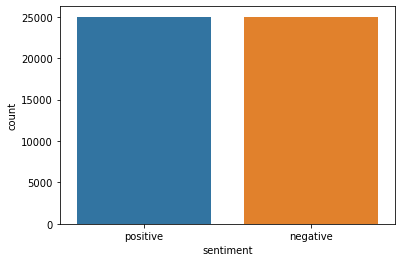

In [ ]:
#1: Reading the file, incorporating the dataset into training and testing instances

#Read file
dataset = pd.read_csv("IMDB Dataset.csv")

print("Dataset content (Reviews, collumns): ", dataset.shape)
print("\nThe look of the dataset:\n")
print(dataset.describe)
print("\nReview of the dataset destribution:\n")
sns.countplot(dataset["sentiment"])

In [ ]:
#Separate the dataset for training (40000) and testing (10000)
dataset_train, dataset_test, train_data_label, test_data_label = train_test_split(
dataset['review'],
dataset['sentiment'],
test_size = 0.20,
random_state = 42)
print("The shape of training dataset: 40,000 Reviews\nThe shape of testing dataset: 10,000 Reviews")

The shape of training dataset: 40,000 Reviews
The shape of testing dataset: 10,000 Reviews


In [ ]:
#2: Pre-processing the raw text for further analysis and an increase in model performance

#Turn 'Positive' -> 1, and 'Negative' -> 0 for numerical representation
# train_data_label = (train_data_label.replace({
#     'positive': 1,
#     'negative': 0})).values
# test_data_label = (test_data_label.replace({
#     'positive': 1,
#     'negative': 0})).values
def numerical_label_conversion(data_label):
    return (data_label.replace({'positive': 1, 'negative': 0})).values
train_data_label = numerical_label_conversion(train_data_label)
test_data_label = numerical_label_conversion(test_data_label)

In [ ]:
#Pre-process the data to increase performance
def process_data(dataset):
    stopwords = nltk.corpus.stopwords.words('english')
    lemmatizer = nltk.stem.WordNetLemmatizer()
    
    #remove punctuation, since it doesn't contribute anything
    def remove_punctuation(review):
        return pattern.sub(' ', review)
    
    #turn words with different forms into one
    def lemmatize(words):
        return ' '.join(lemmatizer.lemmatize(word) for word in words)
    
    #Presence of stopwords does not contribute to the sentiment, thus remove them
    def filter_stopwords(words):
        return filter(lambda word: word not in stopwords, words)

    def process_review(review):
        # Remove HTML tags and convert to lowercase
        review = BeautifulSoup(review, 'html.parser').get_text().lower()
        # Remove punctuation and non-alphabetic characters
        review = remove_punctuation(review)
        # Tokenize the review
        review = review.split()
        # Remove stopwords
        review = filter_stopwords(review)
        # Lemmatize the words
        review = lemmatize(review)
        return review

    return [process_review(review) for review in dataset]

#apply pre-processing to the data
corpus_train = process_data(dataset_train)
corpus_test = process_data(dataset_test)

Linguistic Statistics:

Mean review length: 804.756625
Standard deviation of review lengths: 624.5655144527349
Average number of unique words per review: 27.00405

Dataset Features:

Token Frequency of all reviews: 
Word: movie	Freq: 82475
Word: film	Freq: 74640
Word: one	Freq: 44412
Word: like	Freq: 32834
Word: time	Freq: 25177
Word: good	Freq: 23778
Word: character	Freq: 22607
Word: story	Freq: 20301
Word: even	Freq: 19831
Word: would	Freq: 19696


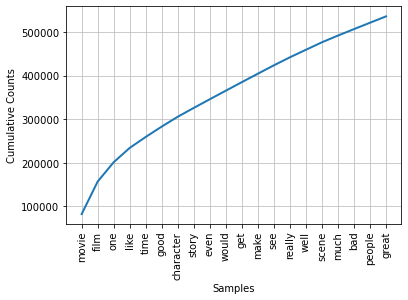


Token Frequency of positive reviews: 
Word: film	Freq: 39630
Word: movie	Freq: 35890
Word: one	Freq: 22540
Word: like	Freq: 14439
Word: time	Freq: 13031
Word: good	Freq: 11962
Word: story	Freq: 11423
Word: character	Freq: 11188
Word: great	Freq: 10422
Word: well	Freq: 10385


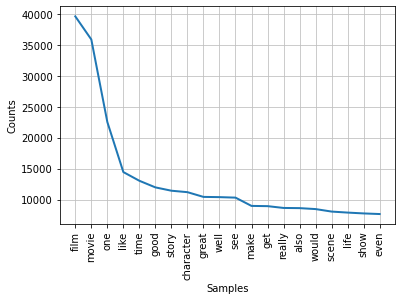


Token Frequency of negative reviews: 
Word: movie	Freq: 46585
Word: film	Freq: 35010
Word: one	Freq: 21872
Word: like	Freq: 18395
Word: even	Freq: 12182
Word: time	Freq: 12146
Word: good	Freq: 11816
Word: bad	Freq: 11782
Word: character	Freq: 11419
Word: would	Freq: 11244


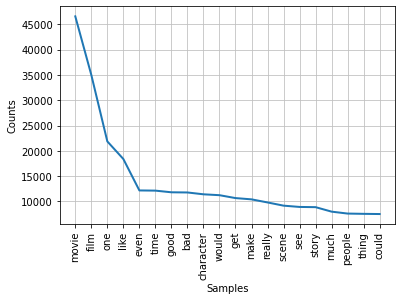

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [ ]:
#3: Analysing the feature of the training set, report the linguistic features of the training dataset.
def data_token_frequency(category):
    #category 1 = positive
    #category 0 = negative
    #category None = None
    if(category != None):
        tokens = [token for review, label in zip(corpus_train, train_data_label) if label == category for token in review.split()]
    elif(category == None):
        tokens = [token for review in corpus_train for token in review.split()]
    else:
        return None
    token_frequency = FreqDist(word for word in tokens)
    return token_frequency

def print_frequency_format(token_frequency, num):
    for word in token_frequency.most_common(num):
        print("Word: " + word[0] + "\tFreq: " + str(word[1]))

def calc_avg_unique_words(reviews):
    num_unique_words = [len(set(review)) for review in reviews]
    return sum(num_unique_words) / len(num_unique_words)


#Lingustic Statistics
print("Linguistic Statistics:\n")

# Calculate the distribution of review lengths
review_lengths = [len(review) for review in corpus_train]
print("Mean review length:", np.mean(review_lengths))
print("Standard deviation of review lengths:", np.std(review_lengths))
print("Average number of unique words per review:", calc_avg_unique_words(corpus_train))

#Dataset Features
print("\nDataset Features:")
all_tokens = data_token_frequency(None)
negative_tokens = data_token_frequency(0)
positive_tokens = data_token_frequency(1)

#Plot the word frequency graphs and 10 most common words
print("\nToken Frequency of all reviews: ")
print_frequency_format(all_tokens, 10)  
all_tokens.plot(20, cumulative = True)

print("\nToken Frequency of positive reviews: ")
print_frequency_format(positive_tokens, 10)  
positive_tokens.plot(20, cumulative = False)

print("\nToken Frequency of negative reviews: ")
print_frequency_format(negative_tokens, 10)  
negative_tokens.plot(20, cumulative = False)

In [ ]:
#4: Building a text classification model, training the model on the training set and testing the model on the test set

#TfidfVectorization of the training and testing set

def vectorize_corpus(corpus_train, corpus_test, ngram_range=(1, 3)):
    tfidf_vec = TfidfVectorizer(ngram_range=ngram_range)
    tfidf_vec_train = tfidf_vec.fit_transform(corpus_train)
    tfidf_vec_test = tfidf_vec.transform(corpus_test)
    return tfidf_vec_train, tfidf_vec_test
tfidf_vec_train, tfidf_vec_test = vectorize_corpus(corpus_train, corpus_test)

In [ ]:
# #Building the model
# linear_svc = LinearSVC(C=0.5, random_state=42)
# linear_svc.fit(tfidf_vec_train, train_data_label)

# #Retrieving the accuracy prediction
# predict = linear_svc.predict(tfidf_vec_test)
# acc_score = accuracy_score(test_data_label, predict)

def train_classifier(classifier, X_train, y_train):
    classifier.fit(X_train, y_train)
    return classifier

def evaluate_classifier(classifier, X_test, y_test):
    predict = classifier.predict(X_test)
    acc_score = accuracy_score(y_test, predict)
    return predict, acc_score

linear_svc = LinearSVC(C=0.5, random_state=42)
linear_svc = train_classifier(linear_svc, tfidf_vec_train, train_data_label)
predict, acc_score = evaluate_classifier(linear_svc, tfidf_vec_test, test_data_label)

LinearSVC Classifier Accuracy: 90.15%

Classification Report: 
               precision    recall  f1-score   support

    Negative       0.91      0.88      0.90      4961
    Positive       0.89      0.92      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000


 Confusion Matrix: 


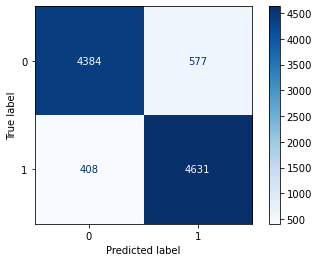

In [ ]:
#5: Summarizing the performance of the model

#Print out the accuracy score
print("LinearSVC Classifier Accuracy:", "{:.2f}%\n".format(100*acc_score))


#printing out the classification report showing off the Precision, Recall and F1-Score
print("Classification Report: \n", classification_report(test_data_label, predict,target_names=['Negative','Positive']))

#Plot the confusion matrix
print("\n Confusion Matrix: ")
plot_confusion_matrix(linear_svc, 
                      tfidf_vec_test, 
                      test_data_label, 
                      cmap = 'Blues')
plt.grid(False)

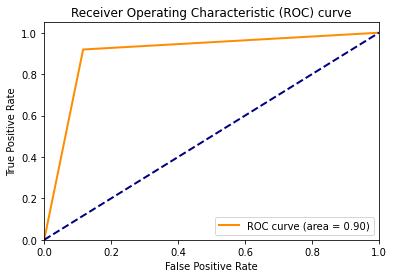

In [ ]:
#Plotting other graphs such as ROC Curve, Learning Curve and Precision-Recall Curve
from sklearn.metrics import roc_curve, auc

#ROC Curve (trade-off between sensitivity and spesificity)
fpr, tpr, _ = roc_curve(test_data_label, predict)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2

#graph spesifics
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

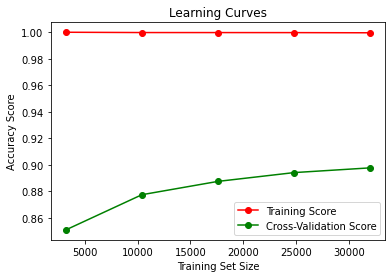

In [ ]:
from sklearn.model_selection import learning_curve

#Learning Curve
train_sizes, train_scores, test_scores = learning_curve(linear_svc, 
                                                        tfidf_vec_train, 
                                                        train_data_label,
                                                        cv=5,
                                                        scoring='accuracy')
#Learning messures
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curves")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation Score")

plt.legend(loc="best")

plt.show()

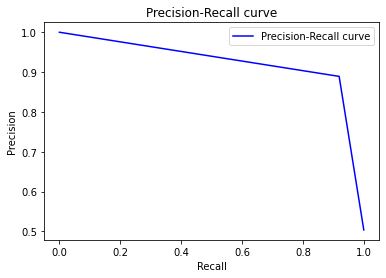

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(test_data_label, predict)

plt.figure()
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='best')
plt.show()

In [ ]:
#Bonus: Sneak peak into model prediction to conclude its performance

#raw data review; copy and reshape accordingly
actual_review = pd.DataFrame(dataset_test.copy())

#Clean and reset the index
actual_review.columns = ['Review']
actual_review = actual_review.reset_index()
actual_review = actual_review.drop(['index'], axis=1)

def sentiment_copy_format(data, column):
    sentiment = data.copy()
    sentiment = pd.DataFrame(sentiment)
    sentiment.columns = [column]
    sentiment[column] = sentiment[column].replace({1: 'Positive', 0: 'Negative'})
    return sentiment

actual_sentiment = sentiment_copy_format(test_data_label, 'Sentiment')
predic_sentiment = sentiment_copy_format(predict, 'Predicted Sentiment')

test_result = pd.concat([actual_review, actual_sentiment, predic_sentiment], axis=1)
test_result.head()

,Review,Sentiment,Predicted Sentiment
0,I really liked this Summerslam due to the look...,Positive,Negative
1,Not many television shows appeal to quite as m...,Positive,Positive
2,The film quickly gets to a major chase scene w...,Negative,Negative
3,Jane Austen would definitely approve of this o...,Positive,Positive
4,Expectations were somewhat high for me when I ...,Negative,Negative
